### 김현진 작업내용 정리
* wandb로 결과치 logging 추가
* X,Y 좌표 결측치 추가
* xy결측치 채우기 : 1_xy_concat.csv 결과 파일
* 대중교통 가중치 : 2_xy_busSubway.csv 결과 파일
* 전용 면적 이상치 제거 (275이상 제거)
* 지하층 1값으로 대체
* 건축년도 신축여부 2009 -> 2004년으로 값 변경* 
* RandomForestRegressor : model = RandomForestRegressor(n_estimators=100, criterion='squared_error', random_state=1, n_jobs=-1, warm_start=True)  
* 수치형, 연속형 변수 : 로그변환
  dt_train[col] = np.log1p(dt_train[col])
  dt_test[col] = np.log1p(dt_test[col])
* 예측값 원복 pred = np.expm1(pred)
* 실제값 원복 y_val = np.expm1(y_val) 
* 삭제: '번지', '고용보험관리번호', 'k-전화번호', 'k-팩스번호',  'k-사용검사일-사용승인일', '청소비관리형태', 'k-관리비부과면적','k-연면적'

# **🏠 부동산 실거래가 Baseline code**
> 부동산 실거래가 예측 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 RandomForest를 활용해 ML 방법론들을 실제 대회에 적용해보도록 하겠습니다.
> 강의는 google colab으로 실행하였기에 아래의 베이스라인 코드와는 일부 차이가 있을 수 있습니다. 

## Contents
- Library Import
- Data Load
- Data Preprocessing
- Feature Engineering
- Model Training
- Inference
- Output File Save


## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [279]:
'''
!pip install eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

# wandb 설치
!pip install wandb -Uq

!pip install plotly
!pip install requests
!pip install aiohttp
!pip install geopy
!pip install geopandas
!pip install shapely
!pip install pyproj
!pip install pyarrow
!pip install lightgbm
'''

'\n!pip install eli5==0.13.0\n\n# 한글 폰트 사용을 위한 라이브러리입니다.\n!apt-get install -y fonts-nanum\n\n# wandb 설치\n!pip install wandb -Uq\n\n!pip install plotly\n!pip install requests\n!pip install aiohttp\n!pip install geopy\n!pip install geopandas\n!pip install shapely\n!pip install pyproj\n!pip install pyarrow\n!pip install lightgbm\n'

### wandb 사이트 가입 후 로그인

In [280]:
import wandb

# 상단에 뜨는 입력 상자에 자신의 키 입력
# wandb.login()

# 또는 wandb.login(key='자신의 키를 한번만 넣어서 돌려주면 file: /data/ephemeral/home/.netrc에 저장되어 내 PC에서는 자동 로그인')

# 하위 주석 풀고 자신의 키 세팅
# wandb.login(key='0b5db')

In [826]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance
import plotly
from sklearn.metrics import r2_score

from geopy.distance import geodesic
from shapely.geometry import Point
import geopandas as gpd
from geopandas.tools import sjoin
import pyproj

import pyarrow.parquet as arrow_parquet
import pyarrow as pa
from lightgbm import LGBMRegressor
import re
import math


## 2. Data Load

#### 2.1. 데이터 로드

In [282]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '../train.csv'
test_path  = '../test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [283]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [284]:
# Train과 Test data를 살펴보겠습니다.
# display(dt.head(1))
# display(dt_test.head(1))      # 부동산 실거래가(=Target) column이 제외된 모습입니다.

## 3. Data Preprocessing

- 모델링 전에 데이터 내 결측치, 이상치 등을 제거하고 범주형과 연속형 변수를 살펴보도록 하겠습니다!
- 먼저, 용이한 전처리를 위해 train과 test data를 합친 하나의 데이터로 진행하도록 하겠습니다.

In [285]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [286]:
concat['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

0    1118822
1       9272
Name: is_test, dtype: int64

In [287]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

### 3.1. 결측치 탐색 및 보간
- 결측치를 처리할 때 많이 쓰는 방법은 삭제(Deletion)과 대체(Imputation) 입니다.
- 본 Baseline에서는 결측치가 90% 이상을 차지하는 변수의 결측치는 제거하고, 나머지 결측치는 대체하도록 하겠습니다.
  - 연속형 변수의 경우에는 선형보간(Linear interpolation)으로 대체하겠습니다.
  - 범주형 변수의 경우에는 'NULL' 이라는 임의의 범주로 대체해주도록 하겠습니다.

- 참고 ✅
  - 선형보간(Linear interpolation)이란 두 점의 값이 주어졌을 때 **그 사이의 값**을 추정하기 위해 직선 거리에 따라 선형적으로 계산하는 방법입니다.
  - 아래 두개의 붉은 점 사이에 ($x$, $y$) 값을 추정하기 위해, 해당 점이 두 붉은 점을 이은 선형적인 선분에 있다고 가정하고, 단순 비례식으로 ($x$, $y$)를 추정해 보간하는 방법입니다.
  - [참고자료](https://ko.wikipedia.org/wiki/%EC%84%A0%ED%98%95_%EB%B3%B4%EA%B0%84%EB%B2%95#:~:text=%EC%84%A0%ED%98%95%20%EB%B3%B4%EA%B0%84%EB%B2%95(%E7%B7%9A%E5%9E%8B%E8%A3%9C%E9%96%93%E6%B3%95,%EC%9C%BC%EB%A1%9C%20%EA%B3%84%EC%82%B0%ED%95%98%EB%8A%94%20%EB%B0%A9%EB%B2%95%EC%9D%B4%EB%8B%A4.)


> 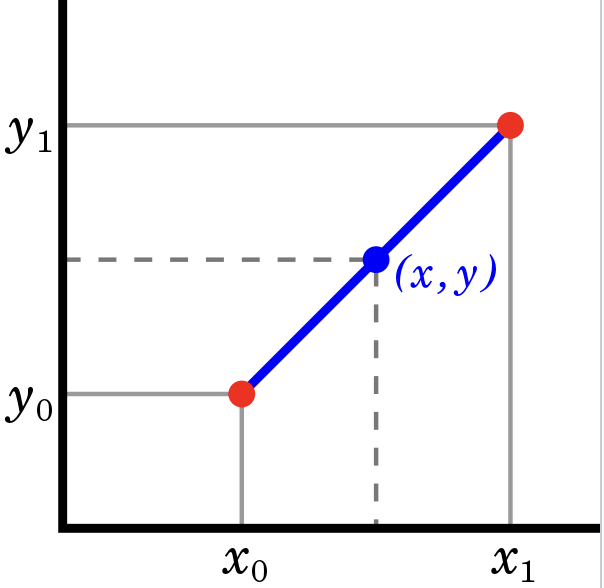

In [288]:
# 실제로 결측치라고 표시는 안되어있지만 아무 의미도 갖지 않는 element들이 아래와 같이 존재합니다.
# 아래 3가지의 경우 모두 아무 의미도 갖지 않는 element가 포함되어 있습니다.
# display(concat['등기신청일자'].value_counts())

In [289]:
# display(concat['거래유형'].value_counts())

In [290]:
# display(concat['중개사소재지'].value_counts())

In [291]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

concat['번지'] = concat['번지'].replace(' ', np.nan)
concat['도로명'] = concat['도로명'].replace(' ', np.nan)

In [292]:
# EDA에 앞서 결측치를 확인해보겠습니다.
display(concat.isnull().sum())
display(len(concat.columns))

시군구                             0
번지                            227
본번                             75
부번                             75
아파트명                         2136
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                          1211
해제사유발생일                   1121899
등기신청일자                    1111271
거래유형                      1086451
중개사소재지                    1090013
k-단지분류(아파트,주상복합등등)         877273
k-전화번호                     876850
k-팩스번호                     879348
단지소개기존clob                1058958
k-세대타입(분양형태)               876125
k-관리방식                     876125
k-복도유형                     876454
k-난방방식                     876125
k-전체동수                     877207
k-전체세대수                    876125
k-건설사(시공사)                 877637
k-시행사                      877834
k-사용검사일-사용승인일              876259
k-연면적                      876125
k-주거전용면적      

53

In [293]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
# fig = plt.figure(figsize=(13, 2))
# missing = concat.isnull().sum() / concat.shape[0]
# missing = missing[missing > 0]
# missing.sort_values(inplace=True)
# missing.plot.bar(color='orange')
# plt.title('변수별 결측치 비율')
# plt.show()

- 위 그래프에서 볼 수 있다시피 결측치가 100만개 이상인 칼럼들은 결측치가 해당 칼럼의 element 중 90% 이상을 차지하는 상황이 됩니다.
- 따라서 본 Baseline 에서는 이 칼럼은 예측에 도움이 되지 않는다고 판단해 삭제해주도록 하겠습니다.

In [294]:
# Null값이 100만개 이상인 칼럼은 삭제해보도록 하겠습니다.
print('* 결측치가 100만개 이하인 변수들 :', list(concat.columns[concat.isnull().sum() <= 1000000]))     # 남겨질 변수들은 아래와 같습니다.
print('* 결측치가 100만개 이상인 변수들 :', list(concat.columns[concat.isnull().sum() >= 1000000]))

* 결측치가 100만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_test']
* 결측치가 100만개 이상인 변수들 : ['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자']


In [295]:
# 위에서 결측치가 100만개 이하인 변수들만 골라 새로운 concat_select 객체로 저장해줍니다.
selected = list(concat.columns[concat.isnull().sum() <= 1000000])
concat_select = concat[selected]
concat_select.head(1)

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0


In [296]:
# 결측치가 100만개 초과인 칼럼이 제거된 모습은 아래와 같습니다.
display(concat_select.isnull().sum())
display(len(concat_select.columns))
# target변수는 test dataset 개수만큼(9272) 결측치가 존재함을 확인할 수 있습니다.

시군구                            0
번지                           227
본번                            75
부번                            75
아파트명                        2136
전용면적                           0
계약년월                           0
계약일                            0
층                              0
건축년도                           0
도로명                         1211
k-단지분류(아파트,주상복합등등)        877273
k-전화번호                    876850
k-팩스번호                    879348
k-세대타입(분양형태)              876125
k-관리방식                    876125
k-복도유형                    876454
k-난방방식                    876125
k-전체동수                    877207
k-전체세대수                   876125
k-건설사(시공사)                877637
k-시행사                     877834
k-사용검사일-사용승인일             876259
k-연면적                     876125
k-주거전용면적                  876170
k-관리비부과면적                 876125
k-전용면적별세대현황(60㎡이하)        876170
k-전용면적별세대현황(60㎡~85㎡이하)    876170
k-85㎡~135㎡이하              876170
k-수정일자                    876170
고용보험관리번호  

45

### 좌표x, 좌표y 결측치 처리

In [297]:
# 외부 데이터로 좌표x, 좌표y 결측치 채운 파일 로드
xy_path = '../outputFinal.csv'
dt_xy = pd.read_csv(xy_path)

In [298]:
# 외부 데이터에서 필요한 데이터 컬럼만 남김
dt_xy_selected = dt_xy.drop(axis=1, columns=['시군구','번지','도로명'])
display(dt_xy_selected.head(2))
display(dt_xy_selected.tail(2))

,좌표X,좌표Y,주소
0,127.05721,37.476763,서울특별시 강남구 개포동 언주로 3
1,127.05721,37.476763,서울특별시 강남구 개포동 언주로 3


,좌표X,좌표Y,주소
1128092,127.063356,37.501358,서울특별시 중랑구 신내동 신내역로1길 85
1128093,127.063356,37.501358,서울특별시 중랑구 신내동 신내역로1길 85


In [299]:
# 두 데이터 프레임의 인덱스를 동일하게 만듭니다. 
# 이렇게 하면 두 데이터 프레임을 병합하거나 다른 연산을 수행할 때 인덱스가 일치하게 됩니다.
# 좌표 데이터 프레임 인덱스 == train + test 데이터 프레임 인덱스
dt_xy_selected.index = concat_select.index

display("인텍스가 동일하게 변경되었습니다.")
display(concat_select.index)
display(dt_xy_selected.index)

dt_xy_selected.head(1)

'인텍스가 동일하게 변경되었습니다.'

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            9262, 9263, 9264, 9265, 9266, 9267, 9268, 9269, 9270, 9271],
           dtype='int64', length=1128094)

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            9262, 9263, 9264, 9265, 9266, 9267, 9268, 9269, 9270, 9271],
           dtype='int64', length=1128094)

,좌표X,좌표Y,주소
0,127.05721,37.476763,서울특별시 강남구 개포동 언주로 3


In [300]:
#좌표 데이터 NaN 데이터
display(concat_select[['시군구','본번','도로명','좌표X','좌표Y']][975:976])
display(dt_xy_selected[975:976])

,시군구,본번,도로명,좌표X,좌표Y
975,서울특별시 강남구 개포동,189.0,삼성로 14,NaN,NaN


,좌표X,좌표Y,주소
975,127.063356,37.501358,서울특별시 강남구 개포동 삼성로 14


In [301]:
# concat 좌표 컬럼의 비어있는 값을 dt_xy_selected 컬럼 '좌표X','좌표Y' 값으로 채우기
concat_select['좌표X'] = concat_select['좌표X'].combine_first(dt_xy_selected['좌표X'])
concat_select['좌표Y'] = concat_select['좌표Y'].combine_first(dt_xy_selected['좌표Y'])


In [302]:
#좌표 데이터 채워진 데이터 확인
display(concat_select[['시군구','본번','부번','도로명','좌표X','좌표Y']][975:976])
display(dt_xy_selected[975:976])

,시군구,본번,부번,도로명,좌표X,좌표Y
975,서울특별시 강남구 개포동,189.0,0.0,삼성로 14,127.063356,37.501358


,좌표X,좌표Y,주소
975,127.063356,37.501358,서울특별시 강남구 개포동 삼성로 14


In [303]:
# 결측치가 모두 채워졌는지 확인
display(concat_select['좌표X'].isna().sum())
display(concat_select['좌표Y'].isna().sum())

0

0

In [304]:
display(len(concat_select.columns))
concat_select.to_csv('../1_xy_concat.csv', index=False)

45

# 여기 이후부터 1_xy_concat.csv 로 Run 가능

In [305]:
# 여기 이후부터 run 시키기 위해 파일로 한번 저장 후 데이터 리로드
concat_select = pd.read_csv('../1_xy_concat.csv')
concat_select.head(1)

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0


### 대중교통 가중치 적용

In [306]:
### 아파트와 지하철 역의 위치 데이터를 사용하여 밀도를 계산하는 함수
# bus-station density, subway-station density

#1. 아파트 위도와 경도 정보를 UTM-K 좌표계로 변환하고, 이를 기반으로 지오메트리 컬럼을 생성합니다.
def preprocess_data(df, x_col, y_col):
    wgs84 = pyproj.CRS('EPSG:4326')  # WGS84 좌표계 (위도, 경도)
    utm_k = pyproj.CRS('EPSG:5179')  # UTM-K 좌표계 (한국)
    project = pyproj.Transformer.from_crs(wgs84, utm_k, always_xy=True).transform
    
    df['geometry'] = df.apply(lambda row: Point(project(row[x_col], row[y_col])), axis=1)
    return gpd.GeoDataFrame(df, geometry='geometry', crs=utm_k)

# 2. 위치 데이터를 사용하여 주어진 반경 내의 밀도를 계산합니다.
def calculate_density(gdf_real_estate, gdf_locations, radius):
    gdf_real_estate['buffer'] = gdf_real_estate.geometry.buffer(radius)
    
    joined = sjoin(gdf_locations, gdf_real_estate.set_geometry('buffer'), how='inner', predicate='within')
    
    density = joined.groupby(joined.index_right).size().rename('density')
    
    return gdf_real_estate.join(density, how='left').fillna(0)['density']


# 큰 데이터프레임을 작은 청크로 나누어 처리하여 메모리 사용을 최적화
def process_in_chunks(df, locations_gdf, radius, chunk_size=10000):
    results = []
    for i in tqdm(range(0, len(df), chunk_size)):
        chunk = df.iloc[i:i+chunk_size]
        chunk_gdf = preprocess_data(chunk, '좌표X', '좌표Y')
        density = calculate_density(chunk_gdf, locations_gdf, radius)
        results.append(density)
    return pd.concat(results)

In [307]:
# 버스, 지하철 데이터
bus_path  = '../bus_feature.csv'
subway_path  = '../subway_feature.csv'

#버스
dt_bus = pd.read_csv(bus_path)
#지하철
dt_subway = pd.read_csv(subway_path)

In [308]:
display(concat_select[['시군구','본번', '좌표X', '좌표Y']].head(1))
display(len(concat_select.columns))
display(dt_bus.head(1))
display(dt_subway.head(1))

,시군구,본번,좌표X,좌표Y
0,서울특별시 강남구 개포동,658.0,127.05721,37.476763


45

,노드 ID,정류소번호,정류소명,X좌표,Y좌표,정류소 타입
0,100000001,1001,종로2가사거리,126.987752,37.569808,중앙차로


,역사_ID,역사명,호선,위도,경도
0,9996,미사,5호선,37.560927,127.193877


In [309]:
# 버스 정류장  X, Y로 변환
bus_gdf = preprocess_data(dt_bus, 'X좌표', 'Y좌표')  # 버스 정류장 좌표계 변환
display(bus_gdf.head(2))

# 지하철 데이터  X, Y로 변환
subway_gdf = preprocess_data(dt_subway, '경도', '위도')  # 지하철 데이터도 동일하게 좌표 변환
display(subway_gdf.head(2))

,노드 ID,정류소번호,정류소명,X좌표,Y좌표,정류소 타입,geometry
0,100000001,1001,종로2가사거리,126.987752,37.569808,중앙차로,POINT (954764.39 1952394.348)
1,100000002,1002,창경궁.서울대학교병원,126.996566,37.579183,중앙차로,POINT (955548.315 1953430.255)


,역사_ID,역사명,호선,위도,경도,geometry
0,9996,미사,5호선,37.560927,127.193877,POINT (972963.732 1951329.788)
1,9995,강일,5호선,37.557490,127.175930,POINT (971377.365 1950953.787)


### 버스 정류소 반경이나 지하철 반경값 조정해서 데이터 학습시켜 볼 수 있음

In [310]:
# 반경 설정
bus_radius = 500  # 미터 단위
subway_radius = 4000  # 1km를 미터 단위로 표현

# 청크 크기 설정
chunk_size = 10000

### 2분 정도 시간 소요

In [311]:
print("버스 정류장 밀도 계산 중 (500m 반경)...")
concat_select['bus_stop_density_500m'] = process_in_chunks(concat_select, bus_gdf, bus_radius, chunk_size)

print("지하철역 밀도 계산 중 (4km 반경)...")
concat_select['subway_station_density_1km'] = process_in_chunks(concat_select, subway_gdf, subway_radius, chunk_size)

# 결과 출력
print(concat_select[['좌표X', '좌표Y', 'bus_stop_density_500m', 'subway_station_density_1km']].head())


버스 정류장 밀도 계산 중 (500m 반경)...


100%|██████████| 113/113 [00:57<00:00,  1.97it/s]


지하철역 밀도 계산 중 (4km 반경)...


100%|██████████| 113/113 [01:17<00:00,  1.45it/s]

         좌표X        좌표Y  bus_stop_density_500m  subway_station_density_1km
0  127.05721  37.476763                     13                          25
1  127.05721  37.476763                     13                          25
2  127.05721  37.476763                     13                          25
3  127.05721  37.476763                     13                          25
4  127.05721  37.476763                     13                          25


In [312]:
# 가중치를 적용:
bus_weight = 0.5  # 예: 버스 밀도에 가중치 0.5
subway_weight = 0.8  # 예: 지하철 밀도에 가중치 0.7

concat_select['대중교통가중치'] = (concat_select['bus_stop_density_500m'] * bus_weight + 
                                       concat_select['subway_station_density_1km'] * subway_weight)
                                       
concat_select= concat_select.drop(columns=['bus_stop_density_500m','subway_station_density_1km'])

In [313]:
display(concat_select.shape)
print(concat_select.columns)
display(concat_select['대중교통가중치'].head(5))
display(concat_select['대중교통가중치'].describe())

(1128094, 46)

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도',
       '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)',
       'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)',
       'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수',
       '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y',
       '단지신청일', 'target', 'is_test', '대중교통가중치'],
      dtype='object')


0    26.5
1    26.5
2    26.5
3    26.5
4    26.5
Name: 대중교통가중치, dtype: float64

count    1.128094e+06
mean     4.396414e+01
std      6.943936e+00
min      5.900000e+00
25%      4.500000e+01
50%      4.500000e+01
75%      4.500000e+01
max      8.950000e+01
Name: 대중교통가중치, dtype: float64

In [314]:
# 여기까지 실행내용 저장
concat_select.to_csv('../2_xy_busSubway.csv', index=False)

#### 대장아파트와의 거리 계산

In [827]:
# 지역구별 대장 아파트들을 입력합니다.
lead_house = {
    "강서구" : (37.56520754904415, 126.82349451366355),
    "관악구" : (37.47800896704934, 126.94178722423047),
    "강남구" : (37.530594054209146, 127.0262701317293),
    "강동구" : (37.557175745977375, 127.16359581113558),
    "광진구" : (37.543083184171, 127.0998363490422),
    "구로구" : (37.51045944660659, 126.88687199829572),
    "금천구" : (37.459818907487936, 126.89741481874103),
    "노원구" : (37.63952738902813, 127.07234254197617),
    "도봉구" : (37.65775043994647, 127.04345013224447),
    "동대문구" : (37.57760781415707, 127.05375628992316),
    "동작구" : (37.509881249641495, 126.9618159122961),
    "마포구" : (37.54341664563958, 126.93601641235335),
    "서대문구" : (37.55808950436837, 126.9559315685538),
    "서초구" : (37.50625410912666, 126.99846468032919),
    "성동구" : (37.53870643389788, 127.04496220606433),
    "성북구" : (37.61158435092128, 127.02699796439015),
    "송파구" : (37.512817775046074, 127.08340371063358),
    "양천구" : (37.526754982736556, 126.86618704123521),
    "영등포구" : (37.52071403351804, 126.93668907644046),
    "용산구" : (37.521223570097305, 126.97345317787784),
    "은평구" : (37.60181702377437, 126.9362806808709),
    "종로구" : (37.56856915384472, 126.96687674967252),
    "중구" : (37.5544678205846, 126.9634879236162),
    "중랑구" : (37.58171824083332, 127.08183326205129),
    "강북구" : (37.61186335979484, 127.02822407466175)
}

In [828]:
# 위경도를 이용해 두 지점간의 거리를 구하는 함수를 생성합니다.
def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6371.0

    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = radius * c
    return distance

# 하위부터 실행 가능 : 2_xy_busSubway.csv 데이터 리로드
1. train, test 데이터 로드

2. concat = pd.concat([dt, dt_test]) : train + test

3. concat['is_test'].value_counts() 
	0    1118822 train 
	1       9272  test

4. np.nan으로 채워 결측치로 인식되도록
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

5. Null값이 100만개 이상인 칼럼은 삭제

6. concat_select.isnull().sum()     # 결측치가 100만개 초과인 칼럼이 제거된 후 값

7. X,Y 좌표(경도,위도)결측치 채우기까지 작업 끝난 상태 파일 저장 후 리로드

8. 대중교통 가중치 적용


In [760]:
# 책갈피1
# 여기서부터 run 시키기 위해 파일로 한번 저장 후 데이터 리로드
concat_select = pd.read_csv('../2_xy_busSubway.csv')
# concat_select.head(1)

In [761]:
# 연속형 변수는 선형보간을 해주고, 범주형변수는 알수없기에 “unknown”이라고 임의로 보간해 주겠습니다.
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128094 entries, 0 to 1128093
Data columns (total 46 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1128094 non-null  object 
 1   번지                      1127867 non-null  object 
 2   본번                      1128019 non-null  float64
 3   부번                      1128019 non-null  float64
 4   아파트명                    1125958 non-null  object 
 5   전용면적                    1128094 non-null  float64
 6   계약년월                    1128094 non-null  int64  
 7   계약일                     1128094 non-null  int64  
 8   층                       1128094 non-null  int64  
 9   건축년도                    1128094 non-null  int64  
 10  도로명                     1126883 non-null  object 
 11  k-단지분류(아파트,주상복합등등)      250821 non-null   object 
 12  k-전화번호                  251244 non-null   object 
 13  k-팩스번호                  248746 non-null   object 
 14  k-

In [762]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
concat_select['본번'] = concat_select['본번'].astype('str')
concat_select['부번'] = concat_select['부번'].astype('str')
# concat_select['번지'] = concat_select['번지'].astype('str')

# 컬럼드랍
# 'k-관리비부과면적' = '주거전용면적'은 거의 비슷 (corr = 0.99)
concat_select = concat_select.drop(columns=[ '번지', '고용보험관리번호', 'k-전화번호', 'k-팩스번호',  'k-사용검사일-사용승인일', '청소비관리형태', 'k-관리비부과면적'])


In [763]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'is_test', '대중교통가중치']
범주형 변수: ['시군구', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-수정일자', '경비비관리형태', '세대전기계약방법', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일']


- 연속형 변수와 범주형 변수가 알맞게 나누어졌는지 확인해보고, 이제 각각 보간을 진행합니다.

In [764]:
# 범주형 변수에 대한 보간
concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat_select[continuous_columns] = concat_select[continuous_columns].interpolate(method='linear', axis=0)

In [765]:
display(concat_select.shape)
display(concat_select.isnull().sum())         # 결측치가 보간된 모습을 확인해봅니다.

(1128094, 39)

시군구                       0
본번                        0
부번                        0
아파트명                      0
전용면적                      0
계약년월                      0
계약일                       0
층                         0
건축년도                      0
도로명                       0
k-단지분류(아파트,주상복합등등)        0
k-세대타입(분양형태)              0
k-관리방식                    0
k-복도유형                    0
k-난방방식                    0
k-전체동수                    0
k-전체세대수                   0
k-건설사(시공사)                0
k-시행사                     0
k-연면적                     0
k-주거전용면적                  0
k-전용면적별세대현황(60㎡이하)        0
k-전용면적별세대현황(60㎡~85㎡이하)    0
k-85㎡~135㎡이하              0
k-수정일자                    0
경비비관리형태                   0
세대전기계약방법                  0
건축면적                      0
주차대수                      0
기타/의무/임대/임의=1/2/3/4       0
단지승인일                     0
사용허가여부                    0
관리비 업로드                   0
좌표X                       0
좌표Y                       0
단지신청일               

- Baseline에서는 단순 결측치들을 제거하거나 보간했지만,
EDA를 통해 변수들의 흐름을 조금 더 파악하고 더 나은 interpolation 등의 방법을 고려해볼 수 있을 것 같습니다.

### 3.2. 이상치 처리
- 이번엔 이상치를 처리해봅시다.
- 이상치를 처리하는 방법은 IQR, Z-score 등 다양한 방법이 있습니다. 가장 쉽고 직관적으로 접근하는 방법은 기본 통계치를 이용하는 것입니다.
- 본 baseline에서는 IQR를 이용한 방법을 사용하겠습니다.

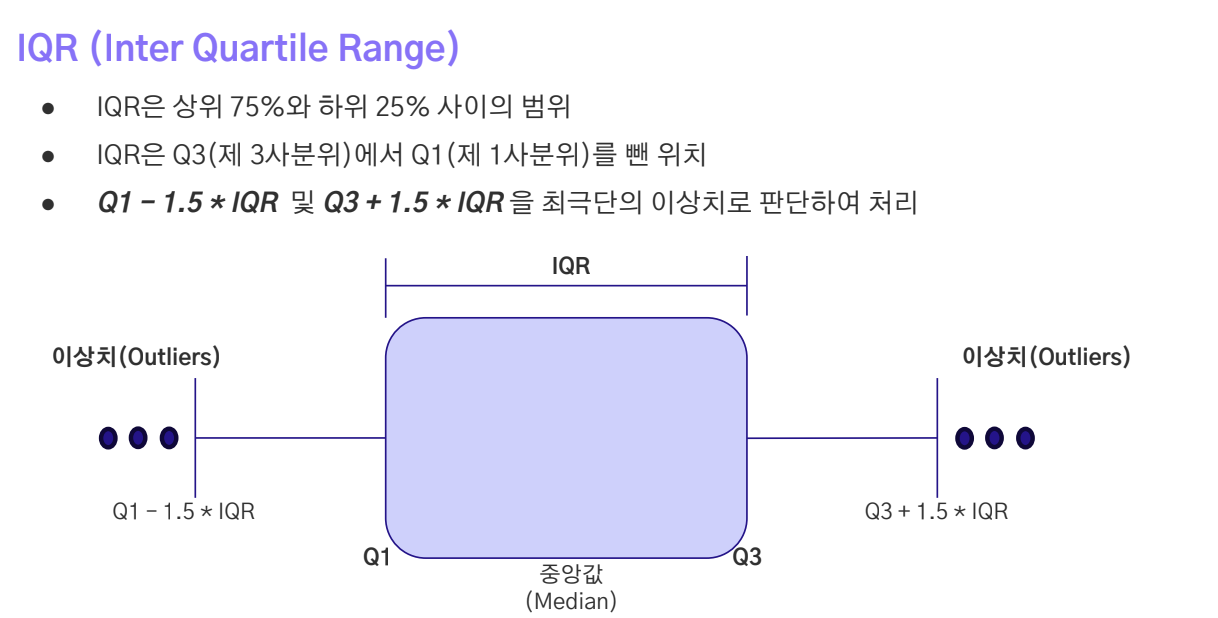

In [766]:
# 이상치 제거 이전의 shape은 아래와 같습니다.
print(concat_select.shape)

(1128094, 39)


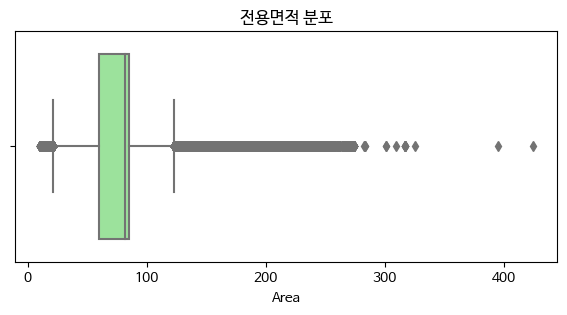

In [767]:
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat_select, x = '전용면적', color='lightgreen')
plt.title('전용면적 분포')
plt.xlabel('Area')
plt.show()

In [768]:
# 이상치 제거 방법에는 IQR을 이용하겠습니다.
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
    df_test = dt.query('is_test == 1')

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
    return result

In [769]:
# 위 방법으로 전용 면적에 대한 이상치를 제거해보겠습니다.
concat_select = remove_outliers_iqr(concat_select, '전용면적')

# 전용면적 275이상인 데이터 출력
concat_select[concat_select['전용면적'] > 275]

# 전용면적 275이상인 데이터 삭제
concat_select = concat_select[concat_select['전용면적'] <= 275]

In [770]:
# 이상치 제거 후의 shape은 아래와 같습니다. 약 10만개의 데이터가 제거된 모습을 확인할 수 있습니다.
print(concat_select.shape)

(1038845, 39)


In [771]:
concat_select['is_test'].value_counts()     # 또한, train data만 제거되었습니다.

0    1029574
1       9271
Name: is_test, dtype: int64

### 지하층은 1값으로 대체

In [772]:
len(concat_select[concat_select['층']<0])

concat_select['층'] = concat_select['층'].apply(lambda x: 1 if x<0 else x)
len(concat_select[concat_select['층']<0])

0

## 4. Feature Engineering
- 이제 파생변수를 만들어보도록 하겠습니다.
- 파생 변수는 도메인 지식에 기반해 제작하는 것이 중요합니다.
- 주택의 가격을 예측하는 문제이기 때문에 약간의 부동산 지식을 기반으로 파생 변수를 만들어 보도록 하겠습니다.

In [773]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat_select['구'] = concat_select['시군구'].map(lambda x : x.split()[1])
concat_select['동'] = concat_select['시군구'].map(lambda x : x.split()[2])
del concat_select['시군구']

concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4])
concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:])
del concat_select['계약년월']

In [ ]:
'''
# 대장 아파트의 위경도 데이터프레임을 구성합니다.
lead_house_data = pd.DataFrame([{"구": k, "대장_좌표X": v[1], "대장_좌표Y": v[0]} for k, v in lead_house.items()])
# 데이터프레임간 결합을 합니다.
# concat_select = pd.merge(concat_select, lead_house_data, how="inner", on="구")
# 아까 제작한 haversine_distance 함수를 이용해 대장아파트와의 거리를 계산하고, 새롭게 컬럼을 구성합니다.
# concat_select['대장아파트_거리'] = concat_select.apply(lambda row: haversine_distance(row["좌표Y"], row["좌표X"], row["대장_좌표Y"], row["대장_좌표X"]), axis=1)
'''

In [ ]:
# lead_house_data

NameError: name 'lead_house_data' is not defined

In [774]:
concat_select.columns

Index(['본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명',
       'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식',
       'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-연면적', 'k-주거전용면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-수정일자', '경비비관리형태', '세대전기계약방법', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
       '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target',
       'is_test', '대중교통가중치', '구', '동', '계약년', '계약월'],
      dtype='object')

- 서울의 집값은 강남, 강북 여부에 따라 차이가 많이 난다는 사실은 많이 알려진 사실입니다.
- 따라서 강남/강북의 여부에 따라 파생변수를 생성해주도록 하겠습니다.

In [775]:
all = list(concat_select['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk)       # 알맞게 분리되었는지 체크합니다.

In [776]:
# 강남의 여부를 체크합니다.
is_gangnam = []
for x in concat_select['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
concat_select['강남여부'] = is_gangnam

In [777]:
display(concat_select.columns)

Index(['본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명',
       'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식',
       'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-연면적', 'k-주거전용면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-수정일자', '경비비관리형태', '세대전기계약방법', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
       '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target',
       'is_test', '대중교통가중치', '구', '동', '계약년', '계약월', '강남여부'],
      dtype='object')

- 또한 신축인지, 구축인지의 여부도 실거래가에 큰 영향을 줄 수 있습니다.
- 따라서 건축년도에 따라 파생변수를 제작해주도록 하겠습니다.

In [778]:
# 건축년도 분포는 아래와 같습니다. 특히 2005년이 Q3에 해당합니다.
# 2009년 이후에 지어진 건물은 10%정도 되는 것을 확인할 수 있습니다.
concat_select['건축년도'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

count    1.038845e+06
mean     1.998583e+03
std      9.132475e+00
min      1.961000e+03
10%      1.987000e+03
25%      1.992000e+03
50%      2.000000e+03
75%      2.005000e+03
80%      2.006000e+03
90%      2.009000e+03
max      2.023000e+03
Name: 건축년도, dtype: float64

In [779]:
# 따라서 2009년 이후에 지어졌으면 비교적 신축이라고 판단하고, 신축 여부 변수를 제작해보도록 하겠습니다.
# 2009 -> 2004년으로 값 변경
concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 1 if x >= 2004 else 0)    

#### 구별 평균 가격 변수 생성

In [780]:
# 구별 평균 가격 계산
gu_mean_price = concat_select.groupby('구')['target'].mean().rename('구별_평균_가격')

# 원본 데이터프레임에 구별 평균 가격 추가
concat_select = concat_select.merge(gu_mean_price, on='구')

In [781]:
display(concat_select['구'].head(1))
display(concat_select['구별_평균_가격'].head(1))

0    강남구
Name: 구, dtype: object

0    95821.426438
Name: 구별_평균_가격, dtype: float64

In [782]:
# 구별 평균 가격 계산
# gu_avg_price = concat_select.groupby('구')['target'].mean().reset_index()

# # 시각화
# plt.figure(figsize=(10, 4))
# sns.barplot(x='구', y='target', data=gu_avg_price)
# plt.title('구별 평균 아파트 가격')
# plt.xlabel('구')
# plt.ylabel('평균 가격')
# plt.xticks(rotation=45)
# plt.show()

In [783]:
concat_select.columns      # 최종 데이터셋은 아래와 같습니다.

Index(['본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명',
       'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식',
       'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-연면적', 'k-주거전용면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-수정일자', '경비비관리형태', '세대전기계약방법', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
       '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target',
       'is_test', '대중교통가중치', '구', '동', '계약년', '계약월', '강남여부', '신축여부',
       '구별_평균_가격'],
      dtype='object')

#### 동별가격, 표준편차

In [784]:
# 동별 평균 가격 및 표준편차 계산
dong_stats = concat_select.groupby('동')['target'].agg(['mean']).rename(columns={'mean': '동별_평균_가격'})

# 원본 데이터프레임에 동별 평균 가격 및 표준편차 추가
concat_select = concat_select.merge(dong_stats, on='동', how='left')

# 컬럼드랍

In [785]:
# 추가적으로 컬럼드랍하고 싶으면 여기서
concat_select.drop(['k-연면적','k-전체세대수', 'k-전용면적별세대현황(60㎡이하)', 
                    'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하'                    
                    ], axis=1, inplace=True)

In [786]:
# 특수 문자를 밑줄로 대체하는 함수
def clean_column_names(df):
    df.columns = [re.sub(r'\W+', '_', col) for col in df.columns]
    return df

# 데이터프레임의 피처 이름 정리 (LGBRegressor 에서 변수명이 문제가 생김)
concat_select = clean_column_names(concat_select)

display(concat_select.columns)
display(concat_select.shape)

Index(['본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명',
       'k_단지분류_아파트_주상복합등등_', 'k_세대타입_분양형태_', 'k_관리방식', 'k_복도유형', 'k_난방방식',
       'k_전체동수', 'k_건설사_시공사_', 'k_시행사', 'k_주거전용면적', 'k_수정일자', '경비비관리형태',
       '세대전기계약방법', '건축면적', '주차대수', '기타_의무_임대_임의_1_2_3_4', '단지승인일', '사용허가여부',
       '관리비_업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_test', '대중교통가중치', '구',
       '동', '계약년', '계약월', '강남여부', '신축여부', '구별_평균_가격', '동별_평균_가격'],
      dtype='object')

(1038845, 40)

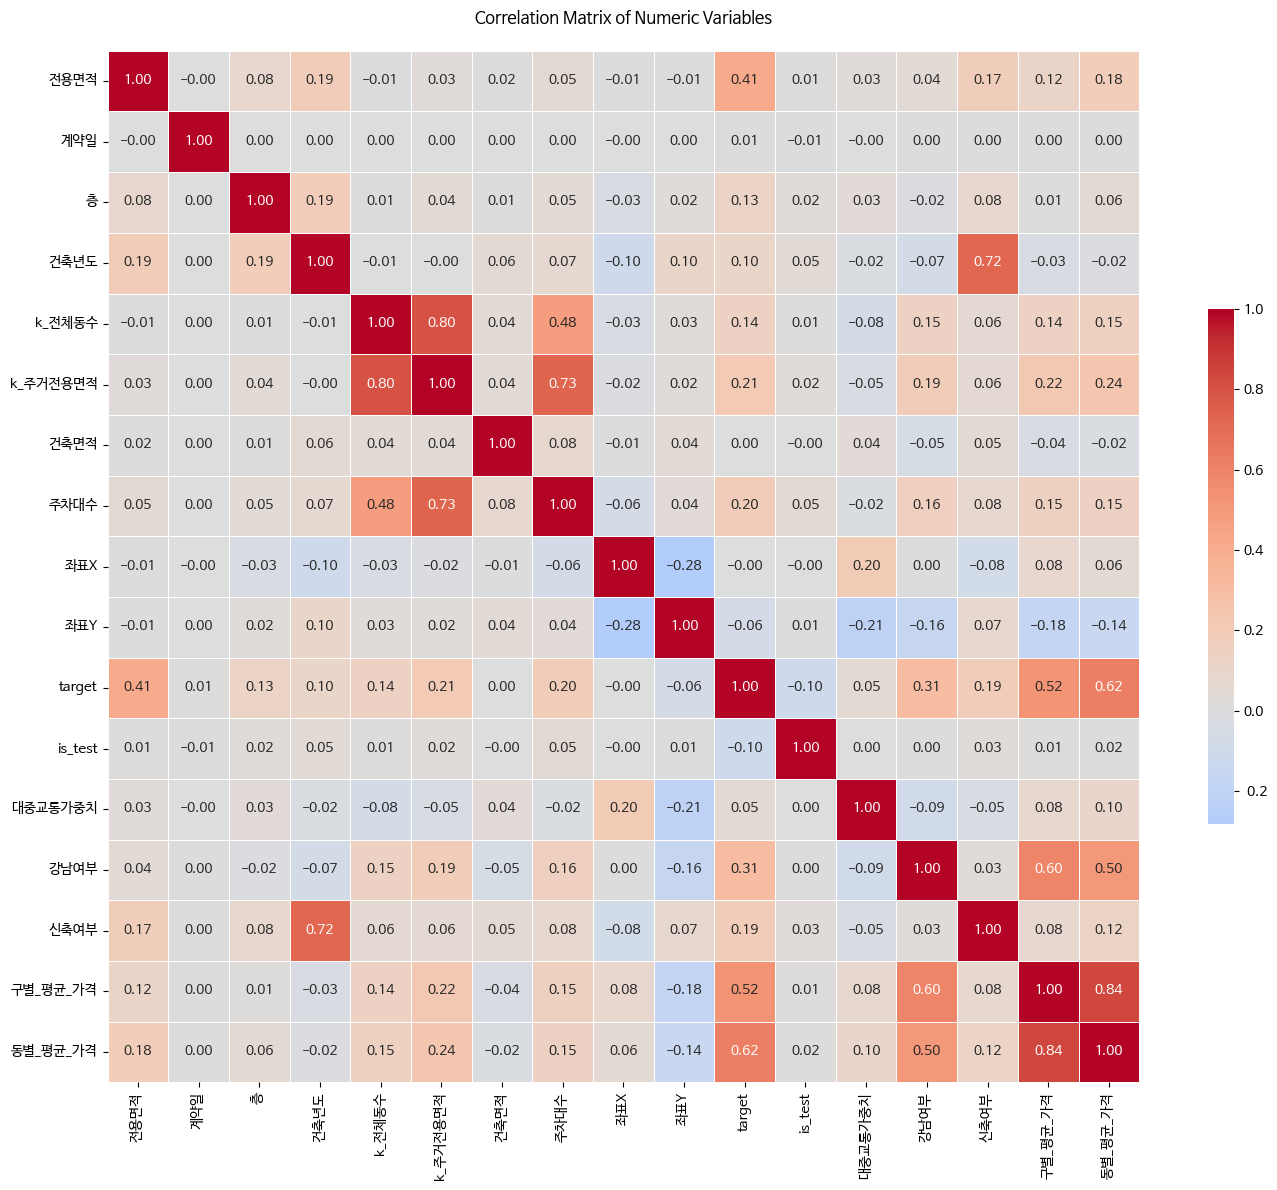

In [787]:
# 변수 간 상관관계 히트맵
# correlation_matrix = concat_select.corr()
# plt.figure(figsize=(12, 12))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.show()

# 연속형 변수들의 상관관계 Heatmap
correlation_matrix = concat_select.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, 
            annot=True,              # 상관계수 표시
            cmap='coolwarm',         # 색
            center=0,                # 상관계수 표시 중심값 0
            fmt='.2f',              # 소수점 2자리 표시
            square=True,            # 정사각형 형태
            linewidths=0.5,         # 그리드 선 두께
            cbar_kws={"shrink": .5} # 색상 바 크기 조절
           )
plt.title('Correlation Matrix of Numeric Variables', pad=20)
plt.tight_layout()
plt.show()

- 위 두 사항 외에도 외부 공공 데이터를 이용하거나, EDA를 통해 더 많은 변수를 제작할 수 있습니다.

## 5. Model Training

- 이제 위에서 만든 파생변수들과 정제한 데이터를 기반으로 본격적으로 부동산 실거래가를 예측하는 모델링을 진행하겠습니다.
- 모델링에는 `sklearn`의 `RandomForest`를 이용하도록 하겠습니다.

- 참고 ✅
  - `RandomForest`는 배깅(Bagging)의 일종으로, 학습시키는 데이터 뿐 아니라 특성변수(X)들도 무작위로 선택해 트리를 생성하는 방법입니다.
  - 모델 학습 과정에서 서로 다른 N개의 Tree 생성하고, N개의 Tree에서 발생한 Output을 Voting(범주형, 분류문제)하거나, Average(연속형, 회귀문제)해 최종 Output 생성합니다.
  - 이는 High variance, Low bias 상황에서 분산(Variance) 감소에 도움을 줍니다.

In [788]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1029574, 39) (9271, 39)


In [789]:
dt_test.head(1).T

,57148
본번,658.0
부번,1.0
아파트명,개포6차우성
전용면적,79.97
계약일,26
층,5
건축년도,1987
도로명,언주로 3
k_단지분류_아파트_주상복합등등_,아파트
k_세대타입_분양형태_,분양


In [790]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

### 5.1. 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

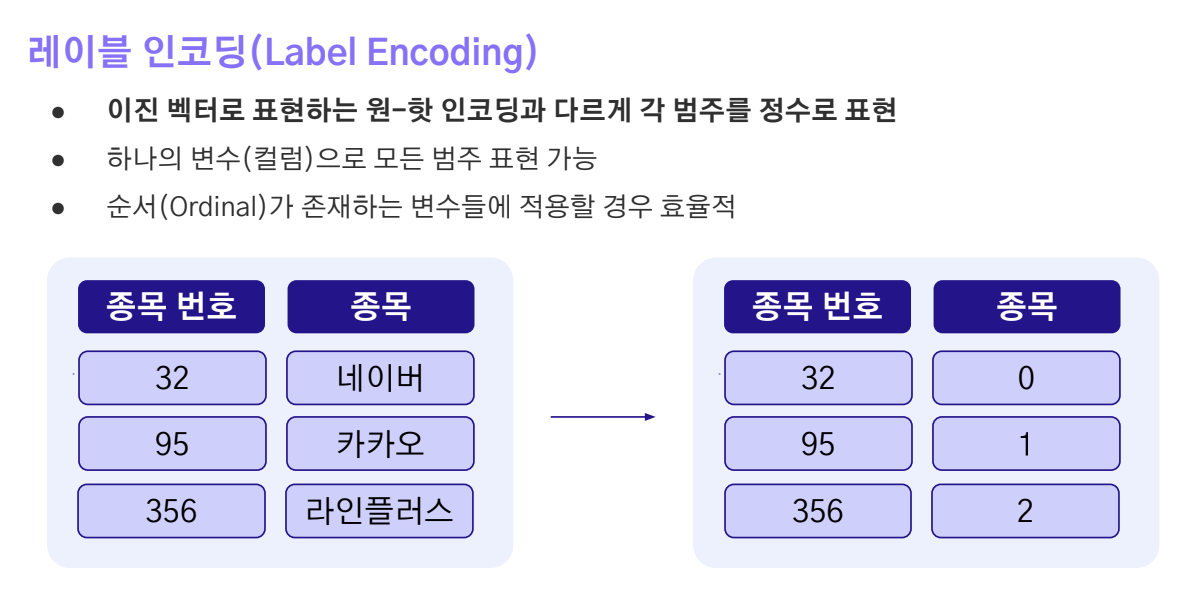

In [791]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', 'k_전체동수', 'k_주거전용면적', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', '대중교통가중치', '강남여부', '신축여부', '구별_평균_가격', '동별_평균_가격']
범주형 변수: ['본번', '부번', '아파트명', '도로명', 'k_단지분류_아파트_주상복합등등_', 'k_세대타입_분양형태_', 'k_관리방식', 'k_복도유형', 'k_난방방식', 'k_건설사_시공사_', 'k_시행사', 'k_수정일자', '경비비관리형태', '세대전기계약방법', '기타_의무_임대_임의_1_2_3_4', '단지승인일', '사용허가여부', '관리비_업로드', '단지신청일', '구', '동', '계약년', '계약월']


#### 수치형, 연속형 변수 : 로그변환

In [792]:
# continuous_columns_v2 로그변환
for col in continuous_columns_v2:
    dt_train[col] = np.log1p(dt_train[col])
    dt_test[col] = np.log1p(dt_test[col])

# dt_train[continuous_columns_v2].head(5).T        # 로그변환이 된 모습입니다.

#### 범주형 : 레이블 인코딩

In [793]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|██████████| 23/23 [00:05<00:00,  3.96it/s]


In [794]:
# dt_train[categorical_columns_v2].head(5).T        # Label Encoding이 된 모습입니다.

In [795]:
dt_train.head(1).T        # 레이블인코딩이 된 모습입니다.

,0
본번,1114.000000
부번,1.000000
아파트명,293.000000
전용면적,4.394079
계약일,2.197225
층,1.386294
건축년도,7.594884
도로명,5520.000000
k_단지분류_아파트_주상복합등등_,3.000000
k_세대타입_분양형태_,2.000000


### 5.2. Model Training
- 위 데이터를 이용해 모델을 train 해보겠습니다. 모델은 RandomForest를 이용하겠습니다.
- Train과 Valid dataset을 분할하는 과정에서는 `holdout` 방법을 사용하겠습니다. 이 방법의 경우  대략적인 성능을 빠르게 확인할 수 있다는 점에서 baseline에서 사용해보도록 하겠습니다.
  - 이 후 추가적인 eda를 통해서 평가세트와 경향을 맞추거나 kfold와 같은 분포에 대한 고려를 추가할 수 있습니다.

In [796]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [797]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

# RandomForestRegressor

In [798]:
'''
# RandomForestRegressor를 이용해 회귀 모델을 적합시키겠습니다.
prjName = "RandomForestRegressor를"
model = RandomForestRegressor(n_estimators=200, criterion='squared_error', random_state=1, n_jobs=-1, warm_start=True)
model.fit(X_train, y_train)
#예측
pred = model.predict(X_val)
'''

'\n# RandomForestRegressor를 이용해 회귀 모델을 적합시키겠습니다.\nprjName = "RandomForestRegressor를"\nmodel = RandomForestRegressor(n_estimators=200, criterion=\'squared_error\', random_state=1, n_jobs=-1, warm_start=True)\nmodel.fit(X_train, y_train)\n#예측\npred = model.predict(X_val)\n'

# LGBMRegressor

In [799]:
# 책갈피2
# LightGBM 데이터셋 생성
# LGBMRegressor 모델 생성 및 학습
prjName = "LGBMRegressor"
model = LGBMRegressor(n_estimators=10000, 
                      criterion='squared_error', 
                      max_depth=10,                       
                      random_state=1)
                      
model.fit(X_train, y_train)
#예측
pred = model.predict(X_val)

[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4675
[LightGBM] [Info] Number of data points in the train set: 823659, number of used features: 38
[LightGBM] [Info] Start training from score 10.706518
[LightGBM] [Warning] Unknown parameter: criterion


#### 수치형 로그 변환 원복

In [800]:
# 예측값 원복
pred = np.expm1(pred)

# 실제값 원복
y_val = np.expm1(y_val)


In [801]:
y_val

903874      81900.0
1006989     27000.0
815557      54500.0
243999      69800.0
535646      50000.0
             ...   
499780      27975.0
509689      54250.0
852576     130000.0
1023252     25000.0
293611      16500.0
Name: target, Length: 205915, dtype: float64

- 랜덤포레스트의 하이퍼파라미터도 데이터에 맞게 지정해줄 수 있습니다. 데이터에 맞는 하이퍼파라미터를 찾는 것도 성능 향상에 도움이 될 수 있습니다.

In [802]:

# 평가 지표 계산
mse = metrics.mean_squared_error(y_val, pred)
rmse = np.sqrt(mse)

# R-squared (R2) 점수는 회귀 모델의 성능을 평가하는 지표 중 하나입니다. 
# 모델이 데이터의 변동성을 얼마나 잘 설명하는지를 나타냅니다. 

# * R2 점수의 특징:
# - 0에서 1 사이의 값을 가집니다.
# - 1에 가까울수록 모델의 성능이 좋다는 것을 의미합니다.
# - 0은 모델이 타겟 변수의 변동성을 전혀 설명하지 못한다는 것을 의미합니다.
# - 음수 값이 나올 수도 있는데, 이는 모델이 평균값보다 못한 예측을 한다는 의미입니다.

r2 = r2_score(y_val, pred)


In [803]:

# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'mse  : {mse}')
print(f'RMSE : {rmse}') #5851.882141463051
print(f'r2 score: {r2}')


mse  : 15704580.214995597
RMSE : 3962.9004800771363
r2 score: 0.9878457068551967


#### wanDB Log : 모델 학습 및 결과

In [804]:
# wandb 초기화
# 모델 데이터 로깅
wandb.init(project="Upstage 집값예측", name=prjName)

# wandb 결과 Log 
wandb.log({
    "MSE": mse,
    "RMSE": rmse,
    "R2 Score": r2
})

# Feature importance 계산 및 로깅
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

wandb.log({"feature_importances": wandb.Table(dataframe=feature_importance)})

# wandb 실행 종료
wandb.finish()

MSE,▁
R2 Score,▁
RMSE,▁
MSE,15704580.215
R2 Score,0.98785
RMSE,3962.90048


- 변수 중요도도 확인해보도록 하겠습니다.

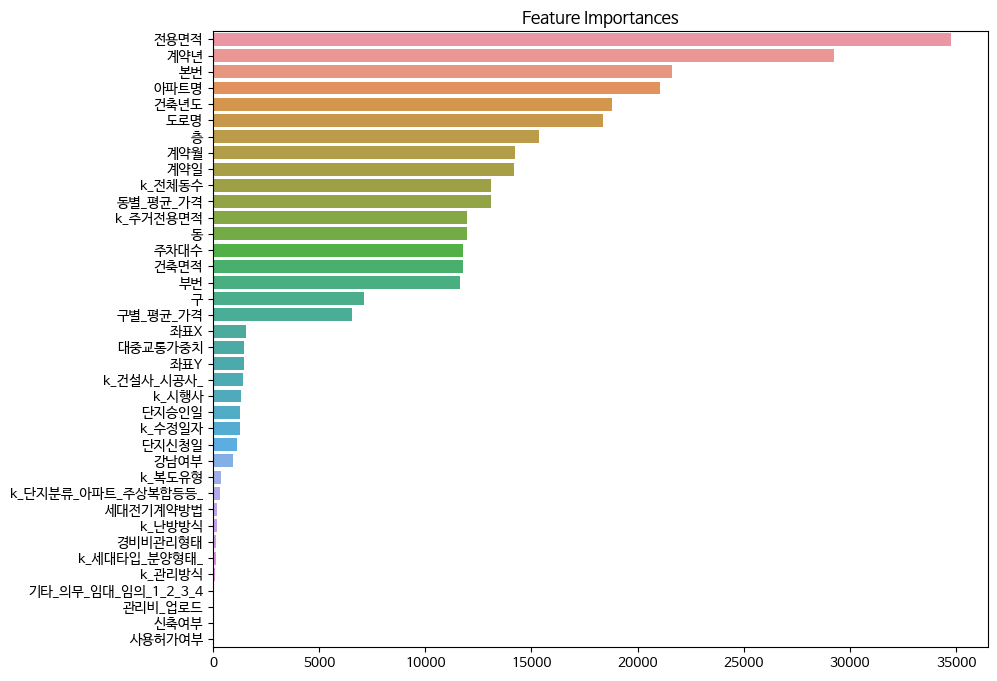

In [805]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [806]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
'''
# 1. 현재 상태 확인
print("X_train columns:", X_train.shape[1])
print("X_test columns:", X_test.shape[1])
# 2. 컬럼 비교
train_cols = set(X_train.columns)
test_cols = set(X_test.columns)
print("\n차이나는 컬럼들:")
print("Train에만 있는 컬럼:", train_cols - test_cols)
print("Test에만 있는 컬럼:", test_cols - train_cols)
'''

X_train columns: 38
X_test columns: 38

차이나는 컬럼들:
Train에만 있는 컬럼: set()
Test에만 있는 컬럼: set()


### 5.3. Feature selection

- 어떤 변수가 유용한 변수인지 확인해보기 위해 permutation selection을 이용해보겠습니다.

In [807]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
# perm = PermutationImportance(model,        # 위에서 학습된 모델을 이용하겠습니다.
#                              scoring = 'neg_mean_squared_error',        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
#                              random_state = 42,
#                              n_iter=3).fit(X_val, y_val)
# eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid data에 대해 적합시킵니다.

- 분석 결과 "계약년", "전용면적" 변수가 유의한 변수로 보입니다. 따라서 이 변수로 또 다른 파생변수를 더 생성해보거나, 중요도가 낮아보이는 변수를 제거해 차원의 저주를 막아볼 수도 있습니다.

### 5.4. Valid prediction 분석

- 예측값을 분석해보기 위해 valid prediction을 확인해보겠습니다.

In [808]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

In [809]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

In [810]:
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [811]:
X_val_sort.head()

,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,k_단지분류_아파트_주상복합등등_,k_세대타입_분양형태_,...,동,계약년,계약월,강남여부,신축여부,구별_평균_가격,동별_평균_가격,target,pred,error
688919,1143,274,3575,4.589904,3.178054,2.079442,7.611348,6112,0,0,...,156,14,2,0.000000,0.693147,11.081205,11.115140,280000.0,122186.586889,2.490507e+10
673012,1223,0,2080,4.686474,2.397895,1.386294,7.587817,5026,0,0,...,111,4,7,0.693147,0.000000,11.478066,11.832409,48000.0,185026.255854,1.877619e+10
13028,1208,0,1472,4.451086,3.258097,3.178054,7.611842,5773,0,0,...,251,15,7,0.693147,0.693147,11.470252,11.439870,150000.0,273230.405673,1.518573e+10
12053,421,105,2466,4.748950,2.564949,0.693147,7.605392,7812,0,0,...,137,15,9,0.693147,0.693147,11.470252,11.468045,352000.0,232373.028275,1.431061e+10
13932,1116,0,3491,4.437461,2.708050,1.386294,7.592870,5772,0,0,...,59,14,8,0.693147,0.000000,11.470252,11.672260,136000.0,255190.117501,1.420628e+10


- 예측을 잘 하지 못한 top 100개의 데이터와 예측을 잘한 top 100개의 데이터를 비교해보겠습니다.

In [812]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

In [813]:
#해석을 위해 수치형 로그 변환 원복
for col in continuous_columns_v2:
    dt_train[col] = np.expm1(dt_train[col])
    dt_test[col] = np.expm1(dt_test[col])

 # 로그변환을 원복한 모습입니다.
# dt_train[continuous_columns_v2].head(5).T  

In [814]:
dt_train['target'].head(1)
dt_test['target'].head(1)

57148    0.0
Name: target, dtype: float64

In [815]:
# 해석을 위해 범주형 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [816]:
display(error_top100.head(1))
display(best_top100.head(1))

,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,k_단지분류_아파트_주상복합등등_,k_세대타입_분양형태_,...,동,계약년,계약월,강남여부,신축여부,구별_평균_가격,동별_평균_가격,target,pred,error
688919,685.0,700.0,아크로서울포레스트,4.589904,3.178054,2.079442,7.611348,왕십리로 83-21,NULL,NULL,...,성수동1가,2021,03,0.0,0.693147,11.081205,11.11514,280000.0,122186.586889,2.490507e+10


,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,k_단지분류_아파트_주상복합등등_,k_세대타입_분양형태_,...,동,계약년,계약월,강남여부,신축여부,구별_평균_가격,동별_평균_가격,target,pred,error
435643,714.0,0.0,삼익4단지,3.703768,3.258097,1.791759,7.598399,동일로198가길 13,NULL,NULL,...,공릉동,2007,07,0.0,0.0,10.411327,10.388099,10500.0,10498.907993,1.192478


- 이제 분포를 비교해보도록 하겠습니다.

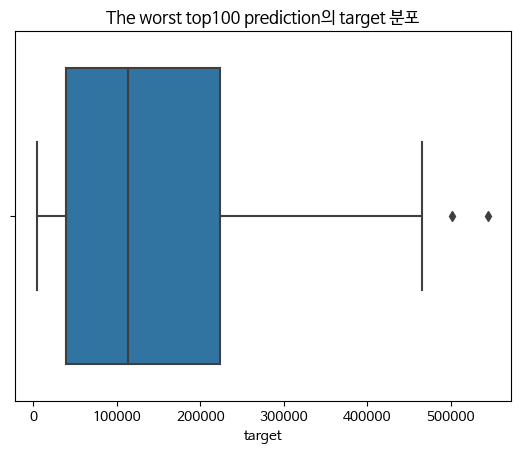

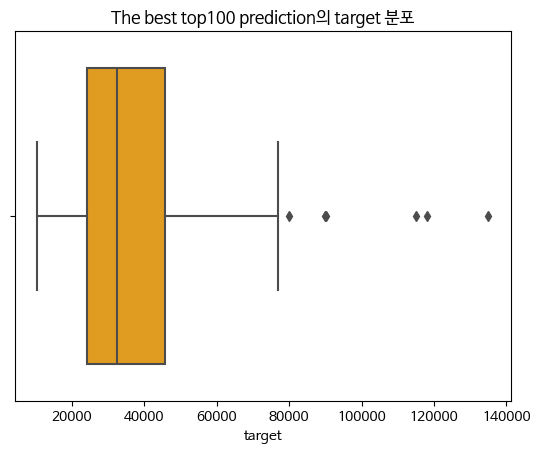

In [817]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

- Taget 분포를 보니 좋은 예측을 보인 top 100개의 data보다 상대적으로 나쁜 예측을 보인 top 100 dataset들이 높은 가격을 보였음을 확인할 수 있습니다. 이에 대한 모델링 및 처리가 필요해보입니다.

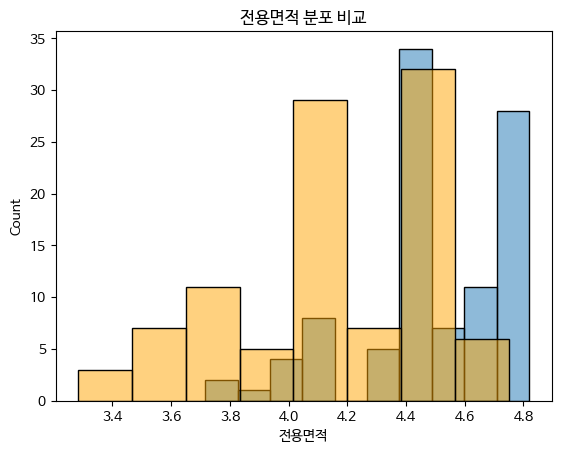

In [818]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

- 전용면적 또한 나쁜 예측을 보인 집들이 더 넓음을 확인할 수 있습니다.

## 6. Inference

In [819]:
dt_test.head(1).T      # test dataset에 대한 inference를 진행해보겠습니다.

,57148
본번,1114.000000
부번,1.000000
아파트명,293.000000
전용면적,79.970000
계약일,26.000000
층,5.000000
건축년도,1987.000000
도로명,5520.000000
k_단지분류_아파트_주상복합등등_,3.000000
k_세대타입_분양형태_,2.000000


In [820]:
# 저장된 모델을 불러옵니다.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [821]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
predicted_log2 = model.predict(X_test)
real_test_pred = np.expm1(predicted_log2) # real_test_pred 로그 변화 원복

[LightGBM] [Warning] Unknown parameter: criterion
CPU times: user 7.43 s, sys: 3.99 ms, total: 7.44 s
Wall time: 879 ms


In [822]:
# real_test_pred 로그 변화 원복
# real_test_pred = np.expm1(real_test_pred)

In [823]:
real_test_pred          # 예측값들이 출력됨을 확인할 수 있습니다.

array([365807.75189434, 312078.95650283, 304623.37406589, ...,
       350117.48121846, 370912.82566169, 345049.87551144])

In [824]:
real_test_pred.shape

(9271,)

## 7. Output File Save

In [825]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)